In [10]:
"""This is video reader with all operations inside fnctions, so they can be called on 
    each frame out of a set of frames, and each video out of a set of videos
    """

'This is video reader with all operations inside fnctions, so they can be called on \n    each frame out of a set of frames, and each video out of a set of videos\n    '

In [11]:
"""Imports"""
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from skimage import measure, morphology
from skimage.morphology import *
from skimage.feature import *
from skimage.filters import *
from skimage.util import invert
from scipy import ndimage
from operator import attrgetter
import numpy as np
import math
from itertools import chain
from glob import glob
#import antigravity

In [12]:
"""Functions"""
"USING THRESHOLD LI"
# read in a file, save the video sequence
def full_avi(filename):
    Vid = skvideo.io.vread(filename)

    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(Vid[0]) # first fame of video
    ax[1].imshow(Vid[-1]) #last frame of video

    print("Video shape is: ", Vid.shape)
    print("Video length is: ", len(Vid))
    
    return Vid

# take a read video; makeit a 2D matrix
def greens(framelist):
    green = framelist[:, :, :, 2]
    #print("This is the green channel of the image")
    #print("The slice shape is: ", green.shape)
    #plt.imshow(green[1], cmap='Greys_r')
    return green


# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, indes):
    # returns a new list, different from the orginal
    fll = len(framelist)
    f_indices = []
    f_ap = f_indices.append
    threshed_images = []
    t_ap = threshed_images.append
    m_lab = measure.label
    m_rop = measure.regionprops
    
    sides = {"t":[], "c":[], "ucf":[]}
    expected_blobs = 4
    expected_connections = 5
    
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        highlight = morphology.erosion(morphology.opening(thresh_img, square(7)),
                                        square(2))
        img = np.copy(frame)
        img[highlight==0] = 0
        blobs =skimage.feature.blob_doh(img, min_sigma = 6, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.75)
        blobset.append(blobs)
        
        num_connections = 0
        num_blobs = len(blobs)
        
        for i in range(num_blobs-1):
            blob = blobs[i]
            radius = blob[2]
            center_vec = (blob[0], blob[1])
            num_connections += connect(center_vec, radius, blobs[i+1::])
        #----------------------filter------------------------- can use actual filter
        
        properties = []
        max_blob = max(blobs, key = third_item)
        cons_of_max = connect((max_blob[0],max_blob[1]),max_blob[2], blobs)
        properties = [num_blobs, num_connections, cons_of_max]
        all_props.append(properties)
            
        test = (num_blobs == expected_blobs
                and num_connections == expected_connections 
               )
        if test: # keep frames that have enough paricles, and are not transitions
            #------proprteis - num connections, presece of biggest sphere
            """properties = []
            max_blob = max(blobs, key = third_item)
            cons_of_max = connect((max_blob[0],max_blob[1]),max_blob[2], blobs)
            properties = [num_blobs, num_connections, cons_of_max]"""
            
            if (cons_of_max == 3 or cons_of_max == 2):
                #-----------------------------classify pt 1---------------------------------------
                f_ap(i) 
                t_ap((img, thresh_img))
                side = sideify(cons_of_max)
                sides[side].append((frame, (img, thresh_img), indes[i]))
                        
    filtrate = framelist[f_indices]
    return [[(filtrate[i], threshed_images[i], indes[i]) for i in range(len(filtrate))], sides]



# take largest isodata image region, and return aclassification
def sideify(cons_of_max):    
    if cons_of_max == 3:
        return "c"
    elif cons_of_max == 2:
        return "t"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    connections = 0
    for blob2 in bloblist:
        cv2 = (blob2[0], blob2[1]) # center of blob2
        if vector_dist(cv, cv2) <= 2*radius: # blob centers closer than diameter of one blob
            connections += 1
        else:
            pass
    return connections

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]   

./tchakamau\Trnansparentd\45400_10Vpp_0.avi
Video shape is:  (37950, 256, 256, 3)
Video length is:  37950


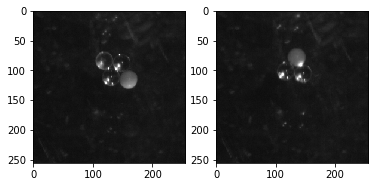

In [13]:
"""Pipeline for videos:"""
# initialize frame list
#filename2 = glob("./tchakamau/New_setup/unstable*.avi")[0]#"./tchakamau/New_setup/45701_10Vpp_18_tester.avi"
filename = glob("./tchakamau/trn*/*[1][0]v*[0,6,2].avi")[0]#glob("./tchakamau/2*/test*.avi")[1]
print(filename)
frame_vid = full_avi(filename) # making videos ino a frame list
#frame_vid_2 = full_avi(filename2) # making videos ino a frame list
#frame_vid = trans_runs= np.load('shape_testing.npy')[0]
#print(frame_vid)
#tf = 61868
#-----------------------------------------------------------------------



In [14]:

h = list(range(0, len(frame_vid), int(len(frame_vid)/300)))
print(len(h))

302


(302, 256, 256, 3)


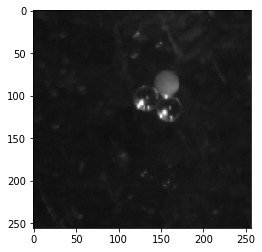

In [15]:
framelist = frame_vid[h]#np.concatenate((frame_vid, frame_vid_2))#np.concatenate((frame_vid[l], frame_vid_2[l2]))# will be replaced by full video
plt.imshow(framelist[-1])
print(framelist.shape)

In [16]:
"""Pipeline for lists of frames"""
"""And test thereof (using isinar)"""
def piped(framelist, h):
    # key variable to be passed into the function is framelist
    green_frames = greens(framelist) # making a green slice
    filtered_frames = total_threshold_filter(green_frames, h)
    return filtered_frames

def isinar(a, als):
    #print(a)
    y = False
    for ele in als:
        #print(ele)
        y = np.array_equal(ele, a)
        if y:
            return y
        else: 
            continue
    return y

org = piped(framelist, h)
twf = org[0]
sids = org[1]
print("unfiltered ", len(framelist))
print("filtered ", len(twf))
print("length of sides ", len([x for y in sids.values() for x in y]))
filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
print("length of filtered out slides ", len(filts))

print("length of side classifs ", [[x, len(sids[x])] for x in sids])

UnboundLocalError: local variable 'framesetname' referenced before assignment

In [ ]:
"""Visualizethe classifiedobjects"""
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    threshes =  [val[1] for val in vals]
    c =5
    r = int(len(vals)/ c)
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            lab = threshes[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(lab[0])
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            lab = threshes[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(lab[1])
    
    

In [ ]:
"""Visualizethe filtered objects"""

frames = filts
c = 5
r = int(len(filts)/ c)
for j in range(r):
    fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
    for k in range(c):
        frame = frames[j * c + k]
        ax[k].set_title(key)
        ax[k].imshow(frame)
    fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
    for k in range(c):
        frame = frames[j * c + k]
        ax[k].set_title(key)
        ax[k].imshow(measure.label(frame > threshold_li(frame)))
    fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
    for k in range(c):
        frame = frames[j * c + k]
        ax[k].set_title(key)
        ax[k].imshow(measure.label(frame > threshold_isodata(frame)))

In [ ]:
frams = framelist
filtered_len = len(twf)

print("unfiltered ", len(frams))
print("filtered ", filtered_len)
#filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
#print("length of filtered out slides ", len(filts))
skeys = list(sids.keys())
print ('skeys', skeys)
slcs = [len(sids[x]) for x in skeys]
ucf = len(sids["ucf"])
print(slcs)
print("length of side classifs ", [[skeys[i], slcs[i], '%.2f' %(slcs[i] *100/ filtered_len)] for i in range(len(skeys))])

In [ ]:
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)
def get_transparent_dot(framelist, threshes_labeled):
    ones = []
    for i in range(len(framelist)):
        frame = framelist[i] 
        threshes = threshes_labeled[i]
        i_threshed  = threshes[1]
        y_threshed  = threshes[0]
        full = largest_region_extractor(y_threshed)
        four = largest_region_extractor(i_threshed)
        one_and_some = full^four
        ones.append(largest_region_extractor(measure.label(one_and_some)))
        
        
        """fig, ax = plt.subplots(ncols = 2)
        ax[0].imshow(one_and_some)
        ax[1].imshow(one)
        #print(one_and_some)
        #print(one)
        plt.show()"""
        
    return ones # A LIST WITH, FOR EACH FRAME, 

In [ ]:
"""OBSERVE THAT DOTS ARE PRINTED RIGHT TO GET BEARINGS"""
#print dots
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    threshes =  [val[1] for val in vals]
    ones = get_transparent_dot(frames, threshes)
    c = 5
    r = int(len(vals)/ c)
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            dot = ones[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(dot)
"""for i in range(0, len(framesets[0:5])):
    fl = [x[0] for x in filtrates[i]]
    ft = [x[1] for x in filtrates[i]]
    ones = get_transparent_dot(fl, ft)
    twf = ones[0:5]
    c = 5
    r = len(twf)// c
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        #fig.set_title(framesetnames[i])
        for k in range(c):
            ax[k].set_title(ft[j * c + k])
            ax[k].imshow(fl[j * c + k])
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        #fig.set_title(framesetnames[i])
        for k in range(c):
            ax[k].set_title(twf[j * c + k][1])
            ax[k].imshow(twf[j * c + k][0])
print("\n\n")"""

In [ ]:
m_rop = measure.regionprops
morph_hull = morphology.convex_hull_image
ave = np.average
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    threshes =  [val[1] for val in vals]
    ones = get_transparent_dot(frames, threshes)
    c = 5
    r = int(len(vals)/ c)
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].imshow(frame)
            ax[k].set_title(key)
        plt.show()
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k] 
            lab = threshes[j * c + k]
            full = morphology.dilation(morphology.closing(largest_region_extractor(lab[0])))
            four = morphology.dilation(morphology.closing(largest_region_extractor(lab[1])))
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            ax[k].imshow(one)
            ax[k].set_title(key)
        plt.show()
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k] 
            lab = threshes[j * c + k]
            full = morphology.dilation(morphology.closing(largest_region_extractor(lab[0])))
            four = morphology.dilation(morphology.closing(largest_region_extractor(lab[1])))
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
            rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
            geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].centroid#m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
            #print(geo_cent)

            cent_x = int(geo_cent[1])#int(ave([geo_cent[1], geo_cent[3]]) )
            cent_y = int(geo_cent[0])#int(ave([geo_cent[0], geo_cent[2]]))
            #print(cent_x, cent_y)

            one_com = m_rop(rotated_one.astype(int))[0].centroid

            rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y) # vector of com of the dot relative to geometric center
            #print("com of dot relative geo_cent", rel_com_one, np.prod(rel_com_one))
            
            #----------
            #----------
            min_vec = (1, 0)
            maj_vec = (0, 1)

            raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
            ys = raw_coords[0]
            #print(m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords)
            xs = raw_coords[1]
            thresh_for_middle = [ys[i] for i in range(len(ys)) if xs[i] == max(xs) ][0]
            xt =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] > thresh_for_middle] 
            yt = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] > thresh_for_middle] 
            xb =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] <= thresh_for_middle] 
            yb = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] <= thresh_for_middle] 
            top = np.zeros((256, 256))
            tbase = np.asarray([yt, xt])
            #print(len(top[base[0]+cent_y, base[1]+cent_x]))
            top[tbase[0]+cent_y, tbase[1]+cent_x] = 1
            #print(len(top), len(np.add(np.asarray([yt, xt]).T, np.array((cent_y, cent_x)))))
            #print(np.asarray([yt, xt]), np.asarray([yt, xt]).T, np.add(np.asarray([yt, xt]).T, np.array((cent_y, cent_x))))
            bottom = np.zeros((256, 256)) 
            bbase = np.asarray([yb, xb])
            #print(len(top[base[0]+cent_y, base[1]+cent_x]))
            bottom[bbase[0]+cent_y, bbase[1]+cent_x] = 1
            ecc_dif = max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).eccentricity - max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).eccentricity            
            tlength = abs(max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).bbox[0]) - abs(max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).bbox[2] )
            blength = abs(max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).bbox[0])- abs(max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).bbox[2]  )
            len_dif = abs(tlength-blength)
            scale = 10
            #plt.plot( np.nonzero(c_hull)[1]- ave(xs),  np.nonzero(c_hull)[0] - ave(ys),'y.')
            ax[k].plot(xt, yt, 'k.')
            ax[k].plot(xb, yb, 'k.')
            #ax[k].plot(top.T[0], top.T[1])
            #ax[k].imshow(measure.label(morphology.dilation(top)), cmap=plt.get_cmap('hot'),)
            ax[k].plot(rel_com_one[0], rel_com_one[1], 'mo', ms=12)
            ax[k].plot([maj_vec[0]*-scale*2, maj_vec[0]*scale*2],
                     [maj_vec[1]*-scale*2, maj_vec[1]*scale*2], color='red')
            ax[k].plot([min_vec[0]*-scale, min_vec[0]*scale],
                     [min_vec[1]*-scale, min_vec[1]*scale], color='blue')
            ax[k].set_title(len_dif)
        #plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

In [ ]:
m_rop = measure.regionprops
morph_hull = morphology.convex_hull_image
ave = np.average
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    threshes =  [val[1] for val in vals]
    ones = get_transparent_dot(frames, threshes)
    c = 5
    r = int(len(vals)/ c)
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].imshow(frame)
            ax[k].set_title(key)
        plt.show()
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k] 
            lab = threshes[j * c + k]
            full = morphology.dilation(morphology.closing(largest_region_extractor(lab[0])))
            four = morphology.dilation(morphology.closing(largest_region_extractor(lab[1])))
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            ax[k].imshow(one)
            ax[k].set_title(key)
        plt.show()
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k] 
            lab = threshes[j * c + k]
            full = morphology.dilation(morphology.closing(largest_region_extractor(lab[0])))
            four = morphology.dilation(morphology.closing(largest_region_extractor(lab[1])))
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
            rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
            geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].centroid#m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
            #print(geo_cent)

            cent_x = int(geo_cent[1])#int(ave([geo_cent[1], geo_cent[3]]) )
            cent_y = int(geo_cent[0])#int(ave([geo_cent[0], geo_cent[2]]))
            #print(cent_x, cent_y)

            one_com = m_rop(rotated_one.astype(int))[0].centroid

            rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y) # vector of com of the dot relative to geometric center
            #print("com of dot relative geo_cent", rel_com_one, np.prod(rel_com_one))
            
            #----------
            #----------
            min_vec = (1, 0)
            maj_vec = (0, 1)

            raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
            ys = raw_coords[0]
            #print(m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords)
            xs = raw_coords[1]
            thresh_for_middle = cent_y
            xt =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] > thresh_for_middle] 
            yt = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] > thresh_for_middle] 
            xb =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] <= thresh_for_middle] 
            yb = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] <= thresh_for_middle] 
            
            length = abs(rel_com_one[1]) 
            scale = 10
            #plt.plot( np.nonzero(c_hull)[1]- ave(xs),  np.nonzero(c_hull)[0] - ave(ys),'y.')
            ax[k].plot(xt, yt, 'k.')
            ax[k].plot(xb, yb, 'k.')
            #ax[k].plot(top.T[0], top.T[1])
            #ax[k].imshow(measure.label(morphology.dilation(top)), cmap=plt.get_cmap('hot'),)
            ax[k].plot(rel_com_one[0], rel_com_one[1], 'mo', ms=12)
            ax[k].plot([maj_vec[0]*-scale*2, maj_vec[0]*scale*2],
                     [maj_vec[1]*-scale*2, maj_vec[1]*scale*2], color='red')
            ax[k].plot([min_vec[0]*-scale, min_vec[0]*scale],
                     [min_vec[1]*-scale, min_vec[1]*scale], color='blue')
            ax[k].set_title(length)
        #plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()